In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la

In [ ]:
T = 10
dt = 0.001
N = int(T/dt + 1)
c0 = 0

In [ ]:
def white_noise(T, dt, c_0, c_k):
    t = np.arange(0, T, dt)
    N = int(T/dt + 1)
    
    k = np.arange(1, int(N/2))
    f_k = k / T
    phi_k = np.random.uniform(0, 2 * np.pi, len(k))
    
    x = []
    for t_i in t:
        x_i = c0/2 + np.sum(c_k * np.sin(2 * np.pi * f_k * t_i + phi_k))
        x.append(x_i)
    return np.array(x)

In [ ]:
t = np.arange(0, 10, dt)
t_i = t[50]
c_k = 1

k = np.arange(1, int(N/2))
f_k = k / T
phi_k = np.random.uniform(0, 2 * np.pi, len(k))
x_i = c0/2 + np.sum(c_k * np.sin(2 * np.pi * f_k * t_i + phi_k))

In [ ]:
v = white_noise(10, 0.001, c_0=0, c_k=1)

In [ ]:
fig = plt.figure()
plt.plot(t, v/200)

In [ ]:
# Generating white noise with randomgaussian coefficients
import numpy as np
import matplotlib.pyplot as plt
from data_fns import butter_bandpass_filter

In [ ]:
def bp_weights(M, N, lowcut, highcut, fs):
    J = np.random.randn(M, N)
    J = butter_bandpass_filter(J, lowcut, highcut, fs)
    return J.T

def bp_weights_gaus(M, N, lowcut, highcut, fs):
    W = np.zeros((M, N))

    t_points = np.arange(N) / fs
    wk = 2 * np.pi * np.arange(lowcut, highcut + 1)
    
    c = 1
    Sk = 1
    for i in range(M):
        Ak = np.random.normal(size=(len(wk), 2))
        for j, t in enumerate(t_points):
            W[i, j] = c / np.sqrt(np.pi) * np.sum(Sk * (Ak[:, 0] * np.cos(wk * t) + Ak[:, 1] * np.sin(wk * t)))
    return W.T

In [ ]:
M = 20
N = 140
fs = 2000
lowcut, highcut = 30, 100

Wgaus = bp_weights_gaus(M, N, lowcut, highcut, fs)
W = bp_weights(M, N, lowcut, highcut, fs)

In [ ]:
i = np.random.randint(M)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(211)
plt.plot(Wgaus.T[i] / np.max(Wgaus.T[i]), label='gaus')
plt.legend()
ax = fig.add_subplot(212)
plt.plot(W.T[i], label='bandpass')
plt.legend()

Generating data using the DFT matrix

In [ ]:
import numpy as np
import numpy.linalg as la
import scipy.linalg
import matplotlib.pyplot as plt

In [ ]:
fs = 200
sig_dur = 0.1

N = int(fs * sig_dur)
t = np.linspace(0, sig_dur, N)

In [ ]:
w, phi = 4, np.pi / 2
A = scipy.linalg.dft(N)
c = np.eye(N)[w] * (np.e ** (1j * phi))
sig = A @ c

In [ ]:
def pure_sine_dft(nPoints, fs, f_signal, sig_dur, a, seed=None):
    
    N = int(fs * sig_dur)
    noise_amp = np.sqrt(1 - a ** 2)
    
    # dft matrix
    A = scipy.linalg.dft(N, scale=None)
    
    # positive examples
    idx = f_signal
    n_pos = int(nPoints/2)
    c = np.zeros((N, n_pos), dtype=complex)
    phi = np.random.uniform(-np.pi, np.pi, (n_pos,)) # randomly sample the phase
    c[idx] = np.e ** (1j * phi) 
    X_pos = np.sqrt(2) * a * (A @ c).T.real + noise_amp * np.random.normal(size=(n_pos, N))
    
    # negative examples 
    X_neg = np.random.normal(size=(n_pos, N))
    
    # concatenate
    X = np.vstack((X_pos, X_neg))
    y = np.hstack((np.ones(n_pos) , np.ones(n_pos) * -1))
    
    return X, y

In [ ]:
X, y = pure_sine_dft(5000, fs=2000, f_signal=8, sig_dur=0.1, a=0.8, seed=20)

t = np.linspace(0, 0.1, X.shape[1])
fig = plt.figure()
plt.plot(t, X[-1])
plt.plot(t, X[0])

In [ ]:
pos = X[y==1]
neg = X[y != 1]
rms_pos = np.mean(la.norm(pos, axis=1))
rms_neg = np.mean(la.norm(neg, axis=1))

print(rms_pos, rms_neg)

In [ ]:
B = scipy.linalg.dft(X.shape[1])
dft_positive = pos @ B
dft_negative = neg @ B

mean_pos = np.mean(dft_positive.real, axis=0)
mean_neg = np.mean(dft_negative.real, axis=0)

In [ ]:

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(221)
plt.plot(mean_pos, c='b', label='positive')
plt.plot(mean_neg, c='r', label='negative')
plt.xlabel('N')
plt.ylabel('DFT real coeff')

ax = fig.add_subplot(222)
i = 8
plt.title('DFT coefficient at signal frequency')
plt.scatter(dft_positive[:, i].real, dft_positive[:, i].imag, marker='s', c='b', alpha=0.3, label='positive')
plt.scatter(dft_negative[:, i].real, dft_negative[:, i].imag, marker='^', c='r', alpha=0.3, label='negative')
plt.xlabel('real')
plt.ylabel('imag')


ax = fig.add_subplot(223)
i=9
plt.title('DFT coefficient at random frequency')
plt.scatter(dft_positive[:, i].real, dft_positive[:, i].imag, marker='s', c='b', alpha=1, label='positive')
plt.scatter(dft_negative[:, i].real, dft_negative[:, i].imag, marker='^', c='r', alpha=0.1, label='negative')
plt.xlabel('real')
plt.ylabel('imag')
plt.tight_layout()
# plt.savefig('figures/rand_classification/dft_data/dft_coef.png')

May 5th, 2020: Generating the data fully using the dft matrix

In [12]:
from data_fns import pure_sine_dft
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import numpy.linalg as la

14.147975368158784 14.177371176446153


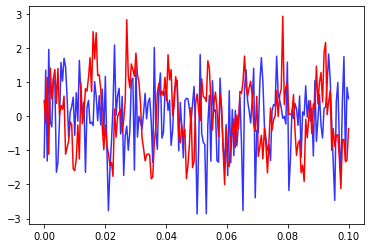

In [13]:
X, y = pure_sine_dft(5000, fs=2000, k=8, sig_dur=0.1, a=0.8, seed=None)

t = np.linspace(0, 0.1, X.shape[1])
fig = plt.figure()
plt.plot(t, X[-1], c='b', alpha=0.8)
plt.plot(t, X[0], c='r')

pos = X[y==1]
neg = X[y != 1]
rms_pos = np.mean(la.norm(pos, axis=1))
rms_neg = np.mean(la.norm(neg, axis=1))

print(rms_pos, rms_neg)

B = scipy.linalg.dft(X.shape[1])
dft_positive = pos @ B
dft_negative = neg @ B

mean_pos = np.mean(dft_positive.real, axis=0)
mean_neg = np.mean(dft_negative.real, axis=0)

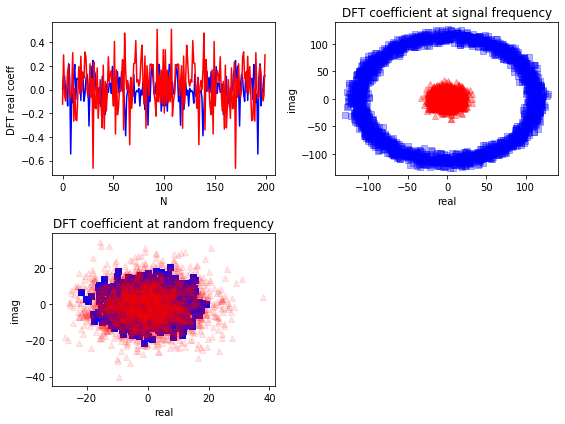

In [14]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(221)
plt.plot(mean_pos, c='b', label='positive')
plt.plot(mean_neg, c='r', label='negative')
plt.xlabel('N')
plt.ylabel('DFT real coeff')

ax = fig.add_subplot(222)
i = 8
plt.title('DFT coefficient at signal frequency')
plt.scatter(dft_positive[:, i].real, dft_positive[:, i].imag, marker='s', c='b', alpha=0.3, label='positive')
plt.scatter(dft_negative[:, i].real, dft_negative[:, i].imag, marker='^', c='r', alpha=0.3, label='negative')
plt.xlabel('real')
plt.ylabel('imag')


ax = fig.add_subplot(223)
i=9
plt.title('DFT coefficient at random frequency')
plt.scatter(dft_positive[:, i].real, dft_positive[:, i].imag, marker='s', c='b', alpha=1, label='positive')
plt.scatter(dft_negative[:, i].real, dft_negative[:, i].imag, marker='^', c='r', alpha=0.1, label='negative')
plt.xlabel('real')
plt.ylabel('imag')
plt.tight_layout()